#  "Прогнозирование количества заказов такси"

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Цель-работы" data-toc-modified-id="Цель-работы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Цель работы</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Цель работы

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor



def make_features(data,window, max_lag):
    for lag in range(1,max_lag):    
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)        
    data['rolling_mean'] =data['num_orders'].rolling(window).mean()  



Загрузим данные о заказах, даты сразу преобразуем в формат datetime 

In [2]:
orders_data=pd.read_csv('/datasets/taxi.csv', sep=',', index_col=[0], parse_dates=[0])
orders_data.head(10)
orders_data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [3]:
orders_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


В файле с данными 2 столбца с информацией о времени и количестве заказов в указанное время. Пропусков в файле нет.

## Анализ

Проверим какие данные есть в файле

In [4]:
print('Начало периода:',orders_data.index.min())

Начало периода: 2018-03-01 00:00:00


In [5]:
print('Конец периода:',orders_data.index.max())

Конец периода: 2018-08-31 23:50:00


In [6]:
orders_data.num_orders.describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

Добавим столбцы с месяцем, числом и днем недели и ресемплируем данные по часам

In [7]:
orders_data = orders_data.resample('1H').sum()
orders_data['dayofweek'] = orders_data.index.dayofweek
orders_data['month'] = orders_data.index.month
orders_data['hour']=orders_data.index.hour

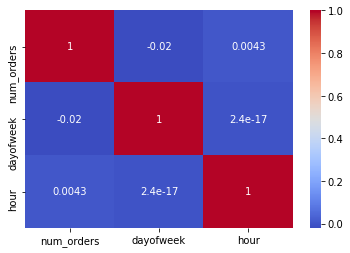

In [8]:
corr_matrix = orders_data[['num_orders','dayofweek','hour']].corr()
sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Матрица корреляции оказалась малоинформативной.

Ресемплируем даные по часу:

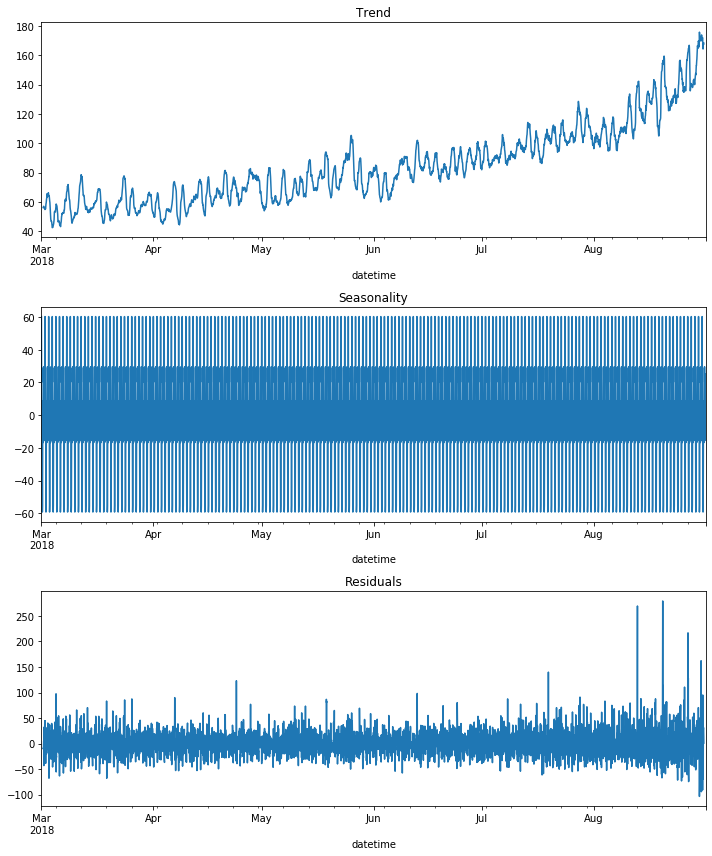

In [9]:
orders_data_resampled_hours = orders_data.resample('1H').sum()
decomposed = seasonal_decompose(orders_data_resampled_hours['num_orders']) 


plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()


Ресемплируем по дням:

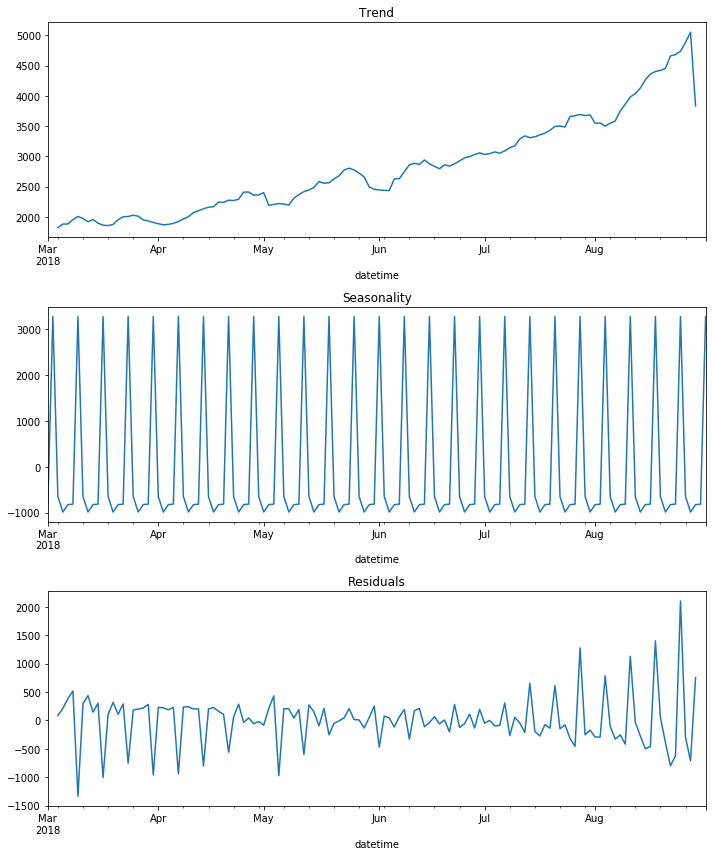

In [10]:
orders_data_resampled_days = orders_data.resample('B').sum()

decomposed = seasonal_decompose(orders_data_resampled_days['num_orders'])

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()


На ресемплированных по дням графиках видны сезонные колебания, на обоих графиках есть тенденция к росту.

## Обучение

Возьмем 2 модели: лес и градиентный бустинг и проверим какая из них покажет нужную нам RMSE не более 48.

Разделим нашу выборку на 3 выборки: обучающую, валидационную и тестовую в пропорции 60:30:10

In [11]:
orders_data=orders_data.dropna()

features=orders_data.drop('num_orders', axis=1)
target=orders_data['num_orders']


train_len=(len(features)//10)*6
valid_len=(len(features)//10)*3
test_len=len(features)-train_len-valid_len


features_train=features.iloc[1:train_len]
features_valid=features.iloc[train_len:train_len+valid_len]
features_test=features.iloc[train_len+valid_len:len(features)+1]

target_train=target.iloc[1:train_len]
target_valid=target.iloc[train_len:train_len+valid_len]
target_test=target.iloc[train_len+valid_len:len(features)+1]

# объединенная выборка(train+valid) для переобучения
features_train_valid=features.iloc[1:train_len+valid_len]
target_train_valid=target.iloc[1:train_len+valid_len]


Обучим случайный лес и проверим какую RMSE он даст

In [12]:
model_rf=RandomForestRegressor()
model_rf.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [14]:
prediction_rf_v=model_rf.predict(features_valid)
RMSE_valid=mean_squared_error(prediction_rf_v,target_valid)**0.5
print('RMSE на валидационной выборке:', round(RMSE_valid,3))

RMSE на валидационной выборке: 33.454


In [15]:
prediction_rf_t=model_rf.predict(features_test)
RMSE_test=mean_squared_error(prediction_rf_t,target_test)**0.5
print('RMSE на тестовой выборке:', round(RMSE_test,3))

RMSE на тестовой выборке: 72.74


Попробуем подобрать гиперпараметры для того, чтобы улучшить качество нашей модели.
Для экономии времени код был закоменчен, параметры подставлены вручную.

In [16]:

#max_lag=60
#max_window=64
#rmse_t=RMSE_valid
#best_model=RandomForestRegressor()
#best_lag=0
#best_window=0
#    
#        
#for lag in range(45,max_lag):
#    for window in range(22, max_window):
#            make_features(orders_data,window,lag)       
#            orders_data=orders_data.dropna()
#            for max_d in range(31,34):
#                for n_est in range(15,18):
#                    model=RandomForestRegressor(max_depth=max_d, n_estimators=n_est)
#                    model.fit(features_train, target_train)
#                    RMSE=mean_squared_error(model.predict(features_valid),target_valid)**0.5
#                    #print('Лаг:', lag,end=' '),
#                    #print('Окно:', window,end=' '),
#                    #print('Глубина:',max_d,end=' '),
#                    #print('Количество деревьев:',n_est,end=' '),
#                    #print('RMSE', round(RMSE,3))
#                    if RMSE<rmse_t:
#                        best_model=model
#                        rmse_t=RMSE
#                        best_lag=lag
#                        best_window=window

In [17]:
#print('Глубина:',best_model.max_depth)
#print('Количество деревьев:',best_model.n_estimators)
#print('RMSE после:',round(rmse_t,3))
#print('RMSE до подбора:',round(RMSE_valid,3))
#print('Лаг:', best_lag)
#print('Окно скользящего среднего:', best_window)

In [18]:
best_model=RandomForestRegressor(max_depth=33, n_estimators=16)

Переобучим модель на объединенной обучающей и валидационной выборке.

In [19]:
best_model.fit(features_train_valid,target_train_valid)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=33,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=16,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Проверим как сработает CatBoost

In [20]:
cat_model = CatBoostRegressor()
cat_model.fit(features_train, target_train, verbose=0)

Проверим RMSE на валидационной выборке:

In [21]:
prediction_cb_v=cat_model.predict(features_valid)
RMSE_cb_v=mean_squared_error(prediction_cb_v,target_valid)**0.5
print('RMSE на валидационной выборке:', round(RMSE_cb_v,3))

RMSE на валидационной выборке: 32.562


In [22]:
prediction_cb_t=cat_model.predict(features_test)
RMSE_cb_t=mean_squared_error(prediction_cb_t,target_test)**0.5
print('RMSE на тестовой выборке:', round(RMSE_cb_t,3))

RMSE на тестовой выборке: 72.973


Попробуем подобрать гиперпараметры и переобучить модель

In [23]:
#
#RMSE_1=RMSE_cb_v
#cb_best_model=CatBoostRegressor()
#max_lag=44
#max_window=43
#best_depth=0
#best_lag=0
#best_window=0
#best_iter=0
#
#
#for lag in range(42,max_lag):
#    for window in range(40, max_window):
#            make_features(orders_data,window,lag)       
#            orders_data=orders_data.dropna()
#            for max_d in range(6,8):
#                for iterat in range(1110,1125):
#                    model=CatBoostRegressor(depth=max_d,verbose=0, iterations=iterat)
#                    model.fit(features_train, target_train)
#                    RMSE=mean_squared_error(model.predict(features_valid),target_valid)**0.5
#                    print('Лаг:', lag,end=' '),
#                    print('Окно:', window,end=' '),
#                    print('Глубина:',max_d,end=' '),
#                    print('RMSE', round(RMSE,3))
#                    if RMSE<RMSE_1:
#                        cb_best_model=model
#                        RMSE_1=RMSE
#                        best_lag=lag
#                        best_window=window
#                        best_depth=max_d
#                        best_iter=iterat
#            

In [24]:
#print('Глубина:',best_depth)
#print('Итерации', best_iter)
#print('RMSE после:',round(RMSE_1,3))
#print('RMSE до подбора:',round(RMSE_cb_v,3))
#print('Лаг:', best_lag)
#print('Окно скользящего среднего:', best_window)

Переобучим модель

In [25]:
cb_best_model=CatBoostRegressor(depth=7,verbose=0, iterations=1116)
cb_best_model.fit(features_train_valid,target_train_valid, verbose=False)

## Тестирование

Проверим обе модели на тестовой выбоке: 

In [26]:
prediction_rf_test=best_model.predict(features_test)
prediction_cb_test=cb_best_model.predict(features_test)

RMSE_test_rf=mean_squared_error(prediction_rf_test,target_test)**0.5
RMSE_test_cb=mean_squared_error(prediction_cb_test,target_test)**0.5

In [27]:
print('RMSE на тестовой выборке для леса:', round(RMSE_test_rf,3))
print('RMSE на тестовой выборке для леса до подбора:', round(RMSE_test,3))

print('RMSE на тестовой выборке для бустинга:', round(RMSE_test_cb,3))
print('RMSE на тестовой выборке для бустинга до подбора:', round(RMSE_cb_t,3))

RMSE на тестовой выборке для леса: 47.399
RMSE на тестовой выборке для леса до подбора: 72.74
RMSE на тестовой выборке для бустинга: 47.464
RMSE на тестовой выборке для бустинга до подбора: 72.973


На всякий случай проверим на константной модели:

In [28]:
adq=np.ones(len(features_test))*target_train.mean()

In [29]:
RMSE_adq_rf=mean_squared_error(prediction_rf_test,adq)**0.5
RMSE_adq_cb=mean_squared_error(prediction_cb_test,adq)**0.5

In [30]:
print('RMSE на константе для леса:', round(RMSE_adq_rf,3))
print('RMSE на константе для бустинга:', round(RMSE_adq_cb,3))

RMSE на константе для леса: 56.715
RMSE на константе для бустинга: 54.931


Построим графики предсказаний и сравним с тестовым значением. Возьмем пару дней второй половины августа

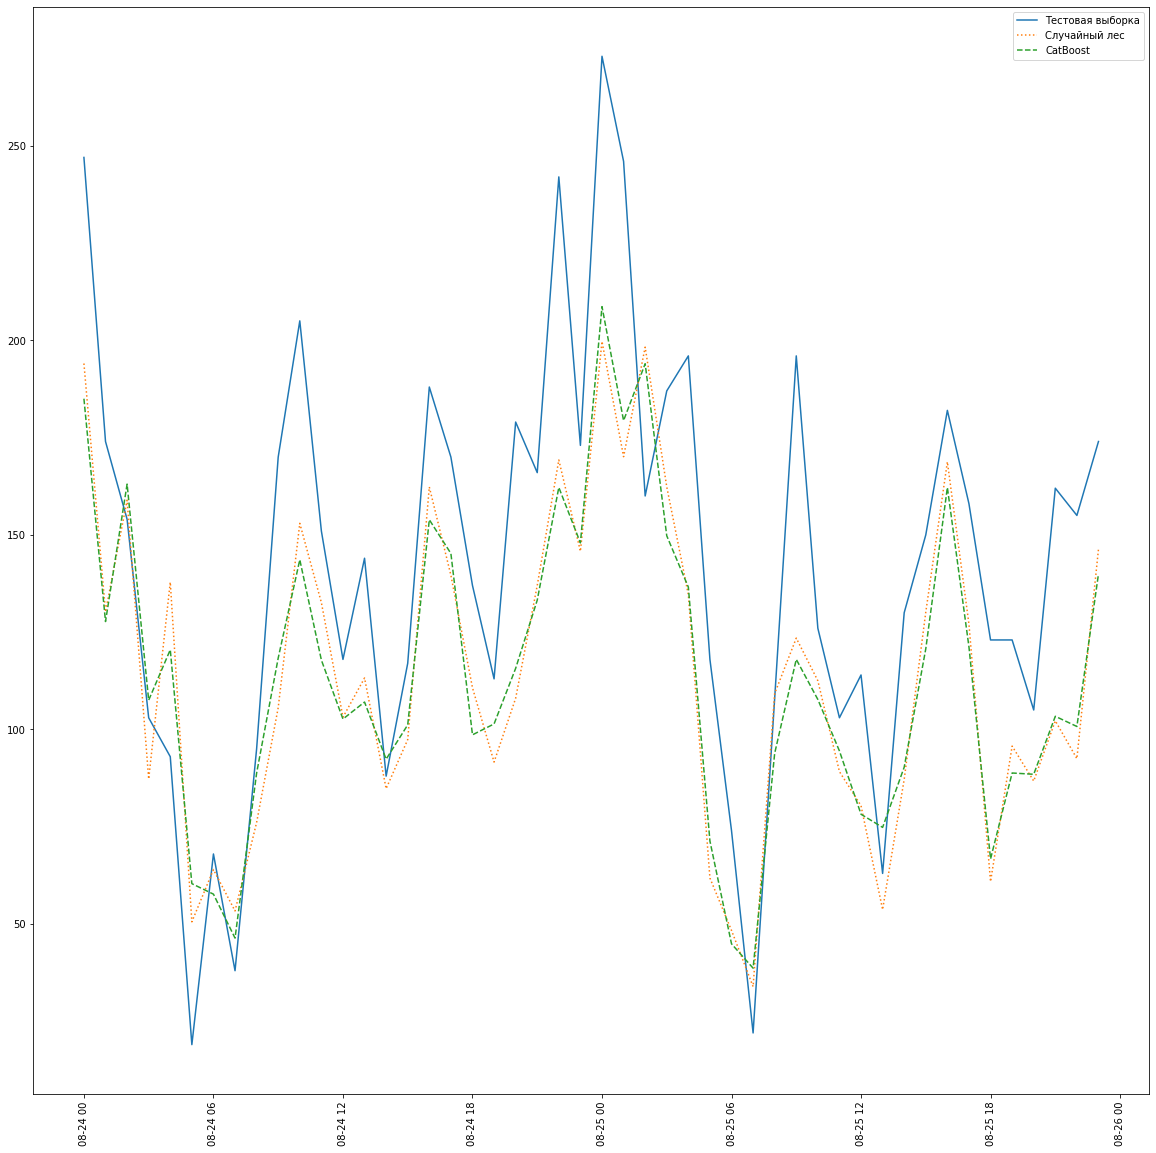

In [41]:
prediction_rf=pd.DataFrame(prediction_rf_test, index=target_test.index)
prediction_cb=pd.DataFrame(prediction_cb_test, index=target_test.index)

idx_1='2018-08-24'
idx_2='2018-08-25'


prediction_rf=prediction_rf.loc[idx_1:idx_2]
prediction_cb=prediction_cb.loc[idx_1:idx_2]
test_rf=target_test.loc[idx_1:idx_2]

fig=plt.figure(figsize=(20, 20))

ax=fig.add_subplot(111)
ax.plot(test_rf.index, test_rf.values, color="C0", label='Тестовая выборка')
ax.plot(prediction_rf.index, prediction_rf.values, color="C1", linestyle=":", label='Случайный лес')
ax.plot(prediction_cb.index, prediction_cb.values, color="C2", linestyle="--",label='CatBoost')
ax.legend()

plt.xticks(rotation=90)
plt.show()



Обе модели некорректно предсказывают пиковые значения, когда идет рост заказов и аналогично в часы спада прогнозные значения сильно ниже фактических, т.е. в обоих случаях можно упустить заказы и прибыль.